# Skin Cancer CNN - by Shailesh Kadre Oct 2022, AI ML C46 Batch

### Problem statement

- To build a CNN based model which can accurately detect melanoma. 
- Melanoma is a type of cancer that can be deadly if not detected early 
- It accounts for 75% of skin cancer deaths. 

### The Solution

- The solution should evaluate images and alert the dermatologists about the presence of melanoma 
- The has a potential to reduce a lot of manual effort needed in diagnosis

### Import Skin Cancer Data

In [1]:
# Import all the important libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
import os
import PIL

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
#train and test images are same in the same dir as the Jupyter Notebook file
train_data_dir = pathlib.Path("Train")
test_data_dir = pathlib.Path("Test")

In [9]:
train_count = len(list(train_data_dir.glob('*/*.jpg')))
test_count = len(list(test_data_dir.glob('*/*.jpg')))

In [10]:
print(train_count)
print(test_count)

2239
118


In [11]:
file_list_train = [len(files) for r, d, files in os.walk("Train")]

In [12]:
file_list_train[1:] # files in 9 cancer classes

[114, 376, 95, 438, 357, 462, 77, 181, 139]

In [13]:
from glob import glob
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')
path_list_origenal = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
len(path_list_origenal)

2239

In [14]:
from os import listdir
from os.path import isfile, isdir, join

In [15]:
root_dir = 'Train'
sub_dirs = [join(root_dir, dir) for dir in listdir(root_dir) if isdir(join(root_dir, dir))]
#sub_dirs

In [16]:
sub_dir_files = [(subdir) for subdir in sub_dirs for f in listdir(subdir) if isfile(join(subdir, f))]
#sub_dir_files
lesion_list_new_origenal=[str(elem).strip('Train\\') for elem in sub_dir_files]
len(lesion_list_new_origenal)

2239

In [17]:
dataframe_dict_new_origenal = dict(zip(path_list_origenal, lesion_list_new_origenal))
df_origenal = pd.DataFrame(list(dataframe_dict_new_origenal.items()),columns = ['Path','Label'])
df_origenal.shape

(2239, 2)

- We will use df_origenal later while working out with class imbalances

### Use keras.preprocessing

### Create a dataset

Define some parameters for the loader:

In [18]:
# Fix the parameters

# batch size
batch_size = 32
# image height and weidth
img_height = 180
img_width = 180

In [19]:
# used seed=123 while creating  
# resized images to the size img_height*img_width, while writting the dataset

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset="training",
    interpolation='bilinear', follow_links=False
) 

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [20]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [21]:
# used seed=123 while creating  
# resized images to the size img_height*img_width, while writting the dataset

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset="validation",
    interpolation='bilinear', follow_links=False
) 

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [22]:
# Make a list for all the 9 classes of skin cancer. Directory names are in alphabetical order.
cancer_class_list = train_data.class_names
cancer_class_list

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [23]:
train_data

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [24]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

### Data Visualization

#### View all the nine cancer classes

In [25]:
for images, labels in validation_data.take(6):
  np_imgages = images.numpy()
  np_labels  = labels.numpy()

In [26]:
print(len(np_imgages))
print(len(np_labels))

32
32


In [27]:
class_labels = []
class_images = []
count = 0
for i in np_labels:
  
  if i not in class_labels:
    class_labels.append(i)
    class_images.append(np_imgages[count])
  count+=1

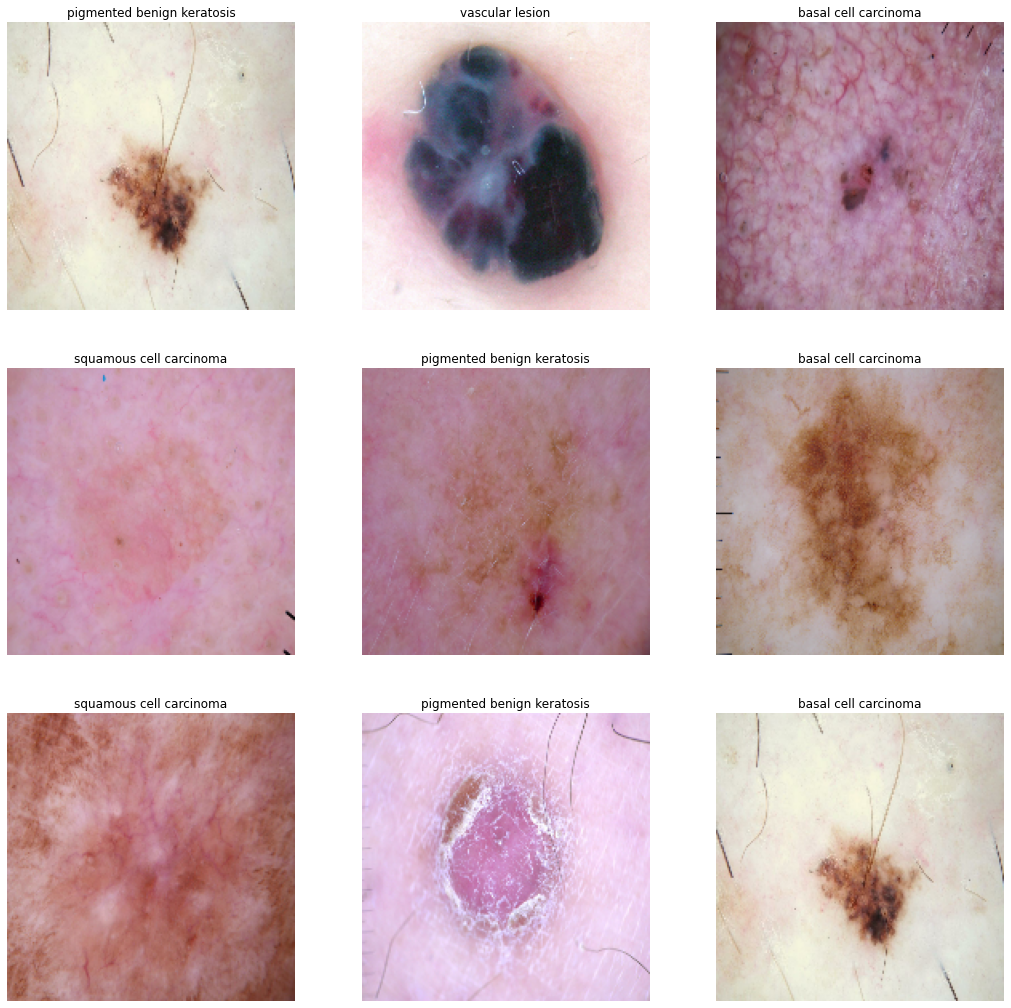

In [28]:
# plot cancer_class_list

plt.figure(figsize= (18,18))
for i in range(9):
  #print("i is",i)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(class_images[i-1].astype("uint8"))
  plt.title(cancer_class_list[labels[i-1]])
  plt.axis("off")

- The image_batch is a tensor of the shape `(32, 180, 180, 3) 
- The label_batch is a tensor of the shape `(32,)

In [29]:
# sanity check
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### Configure the dataset for performance

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

#### Standardize the data

In [31]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [32]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[5]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.038235296 0.96617657


#### Make the model

In [84]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [85]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 128)      

#### Train the model

In [87]:
epochs=30
history = model.fit(
  train_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 36s 631ms/step - loss: 2.0514 - accuracy: 0.2344 - val_loss: 1.8410 - val_accuracy: 0.3177
Epoch 2/30
56/56 [==============================] - 37s 653ms/step - loss: 1.7312 - accuracy: 0.3778 - val_loss: 1.5461 - val_accuracy: 0.4899
Epoch 3/30
56/56 [==============================] - 38s 684ms/step - loss: 1.5070 - accuracy: 0.4643 - val_loss: 1.4676 - val_accuracy: 0.5257
Epoch 4/30
56/56 [==============================] - 38s 682ms/step - loss: 1.4154 - accuracy: 0.4916 - val_loss: 1.4037 - val_accuracy: 0.5391
Epoch 5/30
56/56 [==============================] - 40s 707ms/step - loss: 1.2533 - accuracy: 0.5619 - val_loss: 1.3834 - val_accuracy: 0.4922
Epoch 6/30
56/56 [==============================] - 38s 682ms/step - loss: 1.2003 - accuracy: 0.5664 - val_loss: 1.4099 - val_accuracy: 0.5213
Epoch 7/30
56/56 [==============================] - 40s 712ms/step - loss: 1.1809 - accuracy: 0.5837 - val_loss: 1.3873 - val_accuracy: 0.5436

#### Visualizing training results

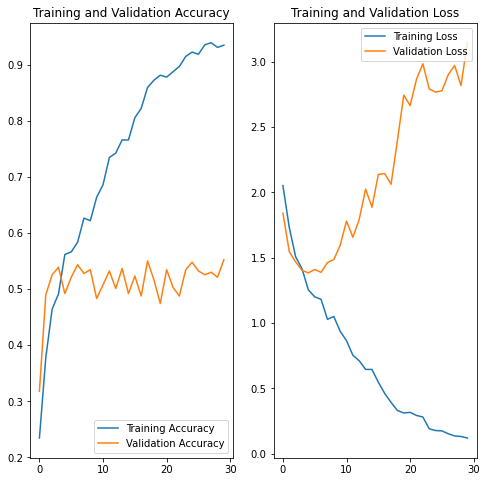

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings on this model

- With the  model1, I got an training accuracy of approximately 94% and validation accuracy of 85% (at 30th epoch) , The model is  overfitting and needs improvements
- We can see that validation accuracy is not incresing above 51 to 55% approximately
- Validation loss is increasing after 5 epochs
- It's a clear case of overfitting

#### Data augmentation

In [38]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

#### Visualize a few augmented examples

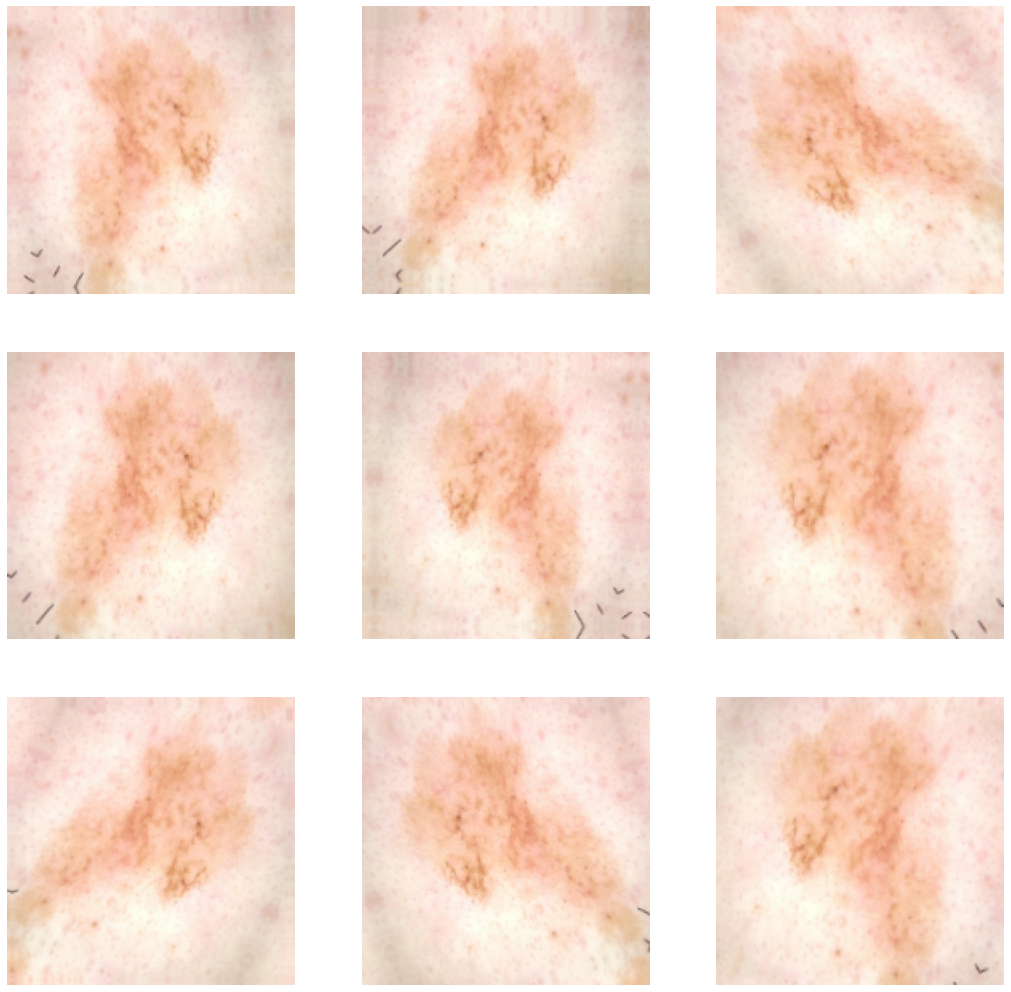

In [39]:
plt.figure(figsize=(18, 18))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Dropout

- Use 20% random dropouts

In [89]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [90]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the new model with dropouts 

In [91]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 45, 45, 128)      

In [92]:
epochs = 30
history = model.fit(
  train_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 38s 672ms/step - loss: 2.0943 - accuracy: 0.2461 - val_loss: 1.7584 - val_accuracy: 0.3468
Epoch 2/30
56/56 [==============================] - 41s 734ms/step - loss: 1.6659 - accuracy: 0.3984 - val_loss: 1.6674 - val_accuracy: 0.4228
Epoch 3/30
56/56 [==============================] - 42s 753ms/step - loss: 1.5383 - accuracy: 0.4537 - val_loss: 1.4621 - val_accuracy: 0.5011
Epoch 4/30
56/56 [==============================] - 41s 729ms/step - loss: 1.4601 - accuracy: 0.4849 - val_loss: 1.4284 - val_accuracy: 0.5101
Epoch 5/30
56/56 [==============================] - 41s 725ms/step - loss: 1.3982 - accuracy: 0.4989 - val_loss: 1.5581 - val_accuracy: 0.4653
Epoch 6/30
56/56 [==============================] - 41s 727ms/step - loss: 1.3818 - accuracy: 0.5184 - val_loss: 1.3540 - val_accuracy: 0.5280
Epoch 7/30
56/56 [==============================] - 41s 737ms/step - loss: 1.2739 - accuracy: 0.5513 - val_loss: 1.2971 - val_accuracy: 0.5481

#### Visualize training results of new model with dropout layer

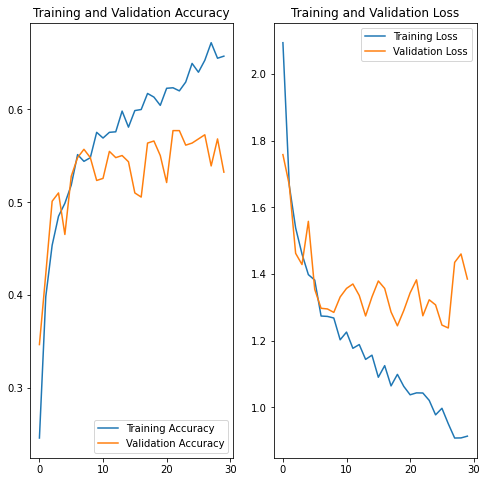

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- The accuracy of model has improved and overfitting reduced
- Accuracy can be further improved

#### Check Class Imbalance

<AxesSubplot:title={'center':'Count of Classes in Various Train Data Folders'}>

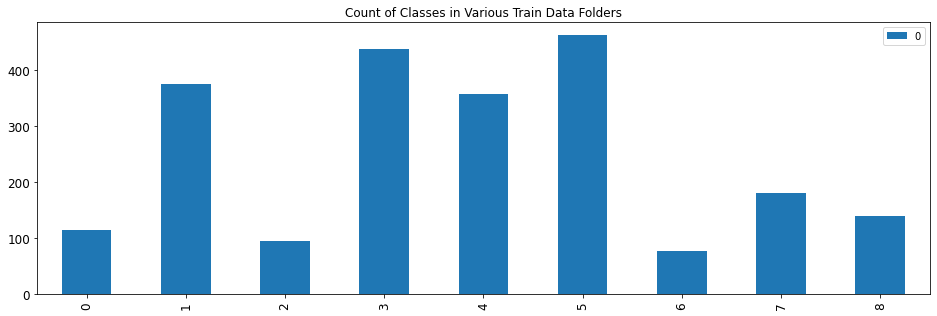

In [45]:
# Plot class imbalance in train
file_list_train = [len(files) for r, d, files in os.walk("Train")]
df_class_no = pd.DataFrame(file_list_train)
df_class_no_new = df_class_no.iloc[1:]
df_class_no_new = df_class_no_new.reset_index(drop=True)
df_class_no_new.plot(kind='bar', title ="Count of Classes in Various Train Data Folders", figsize=(16, 5), fontsize=12)

#### Using Augmentor to treat class imbalance

In [46]:
class_names = cancer_class_list
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [47]:
path_to_training_dataset="Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+"//" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train//actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2083421EF10>: 100%|█| 500/500 [00:03<00:


Initialised with 376 image(s) found.
Output directory set to Train//basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20835794730>: 100%|█| 500/500 [00:04<00:00, 103.93 Samples


Initialised with 95 image(s) found.
Output directory set to Train//dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x208341C0C10>: 100%|█| 500/500 [00:04<00:00, 113.45 Samples


Initialised with 438 image(s) found.
Output directory set to Train//melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x208357947C0>: 100%|█| 500/500 [00:19<00:00, 25.36 Samples


Initialised with 357 image(s) found.
Output directory set to Train//nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x20834222AC0>: 100%|█| 500/500 [00:19<00:


Initialised with 462 image(s) found.
Output directory set to Train//pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20835621520>: 100%|█| 500/500 [00:04<00:


Initialised with 77 image(s) found.
Output directory set to Train//seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x20834203EE0>: 100%|█| 500/500 [00:09<00:00, 50.87 Samples


Initialised with 181 image(s) found.
Output directory set to Train//squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x208342311F0>: 100%|█| 500/500 [00:04<00:00, 110.08 Samples


Initialised with 139 image(s) found.
Output directory set to Train//vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20838F99880>: 100%|█| 500/500 [00:04<00:00, 108.52 Samples


#### Check class imbalance in treated folders

In [48]:
from glob2 import glob

In [49]:
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [50]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [51]:
# Collating .jpg of augmented images
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new

In [52]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [53]:
len(lesion_list_new)

4500

In [54]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [55]:
len(dataframe_dict_new)

4500

In [56]:
# Combine origenal and augmented image labels in a dataset
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.shape
new_df = df_origenal.append(df2) # df_origenal was worked out in the begining of this file

In [57]:
new_df.shape

(6739, 2)

In [58]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [59]:
df_origenal['Label'].value_counts()

pigmented benign keratosis    462
melanom                       438
basal cell carcinom           376
evus                          357
squamous cell carcinom        181
vascular lesio                139
ctinic keratosis              114
dermatofibrom                  95
seborrheic keratosis           77
Name: Label, dtype: int64

In [60]:
#df = df.reset_index()
df_origenal_value_counts = df_origenal['Label'].value_counts().reset_index()

In [61]:
cancer_class_name_aggr_new = df_origenal_value_counts

In [62]:
cancer_class_name_aggr_new
cancer_class_name_aggr_new.columns=['Class', 'Values']

In [63]:
cancer_class_name_aggr_new['Values'] = cancer_class_name_aggr_new['Values'] + 500 # all augmented folder's count is 500

In [64]:
cancer_class_name_aggr_new # sanity check

,Class,Values
0,pigmented benign keratosis,962
1,melanom,938
2,basal cell carcinom,876
3,evus,857
4,squamous cell carcinom,681
5,vascular lesio,639
6,ctinic keratosis,614
7,dermatofibrom,595
8,seborrheic keratosis,577


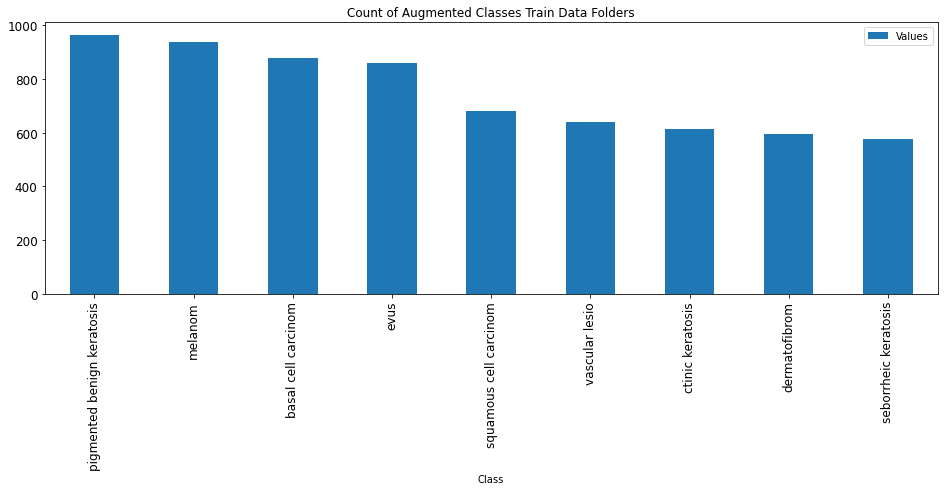

In [65]:
cancer_class_name_aggr_new['Values'] = cancer_class_name_aggr_new['Values'].astype(int)
ax1 = cancer_class_name_aggr_new.plot.bar(x='Class',y='Values',title ="Count of Augmented Classes Train Data Folders", figsize=(16, 5), fontsize=12)

- The distribution is acceptable now after imbalance class treatment

#### Train the model on the data created using Augmentor

In [66]:
data_dir_train="Train" # path to directory with training data + data created using augmentor
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training" ,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [67]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model with data_augmentation and class imbalance treated 

In [77]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile the model (with appropriate optimizer and loss function)

In [78]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the model created after data_augmentation and class imbalance treated

In [79]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data= val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 144s 848ms/step - loss: 1.9173 - accuracy: 0.2687 - val_loss: 1.5575 - val_accuracy: 0.4180
Epoch 2/30
169/169 [==============================] - 144s 847ms/step - loss: 1.5534 - accuracy: 0.4023 - val_loss: 1.5952 - val_accuracy: 0.3964
Epoch 3/30
169/169 [==============================] - 142s 837ms/step - loss: 1.4167 - accuracy: 0.4635 - val_loss: 1.4568 - val_accuracy: 0.4781
Epoch 4/30
169/169 [==============================] - 142s 838ms/step - loss: 1.3405 - accuracy: 0.4866 - val_loss: 1.2697 - val_accuracy: 0.5234
Epoch 5/30
169/169 [==============================] - 142s 838ms/step - loss: 1.2705 - accuracy: 0.5130 - val_loss: 1.2692 - val_accuracy: 0.5160
Epoch 6/30
169/169 [==============================] - 141s 833ms/step - loss: 1.2132 - accuracy: 0.5395 - val_loss: 1.1382 - val_accuracy: 0.5657
Epoch 7/30
169/169 [==============================] - 141s 834ms/step - loss: 1.1608 - accuracy: 0.5616 - val_loss: 1.0556 -

#### Visualize the model final results (third model with dropout, data_augmentation, and class imbalance treated )

In [82]:
epochs = 30 # the model has 30 epochs
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
epochs_range = np.array(list(range(epochs)))

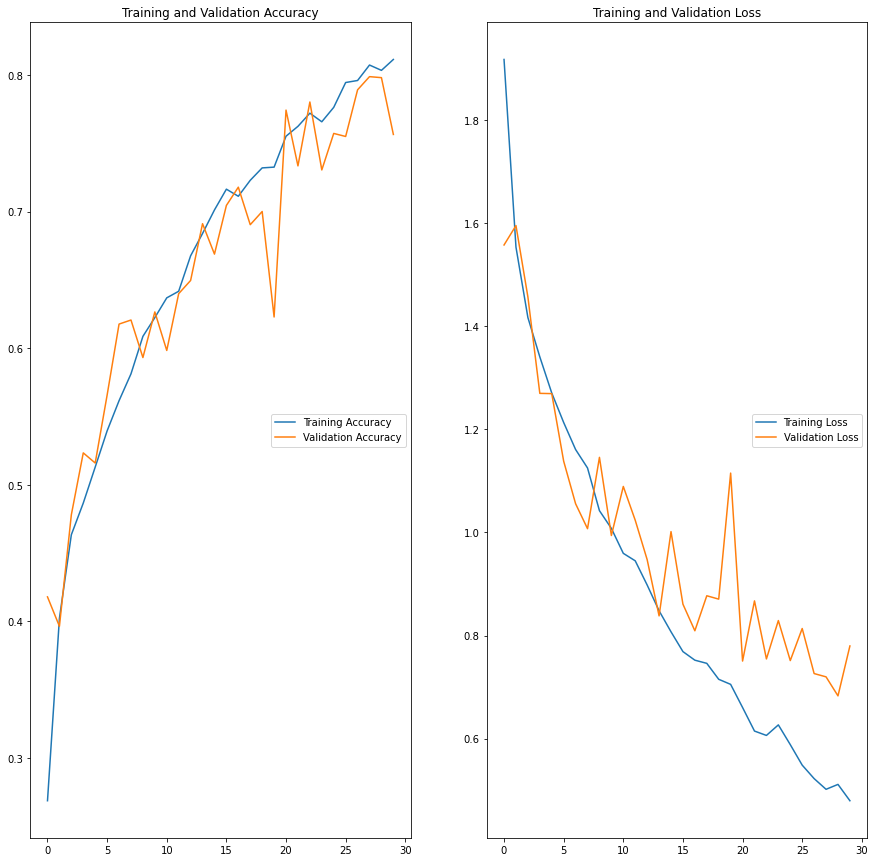

In [83]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='center right') # lower right
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='center right') # upper right
plt.title('Training and Validation Loss')
plt.show()

#### Analysis of results 

- Did you get rid of underfitting/overfitting? 
- Did class rebalance help?

- data_augmentation helped to some extent but the model was still overfitting and accuracy was not satisfacory
- data_augmentation plus class imbalance treatment plus dropout layers definitely helped
- With the final model, I got an training accuracy of approximately 80% and validation accuracy of 80% (at 29th epoch) which is satisfactory, The model is not overfitting with the above improvements 
- The model accuracy can be improved further with still better hyperpameter tuning
- But in the interest of time, we will stop here

#### End of Analysis

- Submitted on 8th May, 2023 Executive PG Programme AI ML C46 Oct 2022 Batch